## PROJECT 34: Amazon Stock Price 1997 to 2020

> ### TASK: Stady Long short-term memory for forecasting time series


### Project goals and objectives

#### Project goal

- Studying **LSTN for forecasting time series**

#### Project objectives

1. Explore and prepare data 
2. Building LSTM model

#### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
sns.set_style('whitegrid')

import re
import math as math

import tensorflow as tf

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteScaledError

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat

import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dropout, Dense, Input,  MaxPool1D
from tensorflow.keras.models import Model

from keras.models import Sequential
from keras.layers import LSTM


import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### LOAD DATA

In [2]:
# Path to data
data_path = "data/Amazon.csv"

In [3]:
# Load the data
data_df = pd.read_csv(data_path, parse_dates=['Date'], index_col=['Date'])

# Check result 
data_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


#### **For further research and model construction, we will take only the time series of the close price.**

In [4]:
# Take a columns
data_df =  data_df[['Close']]

# Check result 
data_df.head()

,Close
Date,
1997-05-15,1.958333
1997-05-16,1.729167
1997-05-19,1.708333
1997-05-20,1.635417
1997-05-21,1.427083


### EXPLORATORY DATA ANALYSIS 

In [5]:
# Check the missing values
print("Check the number of records")
print("Number of records: ", data_df.shape[0], "\n")

print("Null analysis")
empty_sample = data_df[data_df.isnull().any(axis=1)]
print("Number of records contain 1+ null: ", empty_sample.shape[0], "\n")

Check the number of records
Number of records:  5842 

Null analysis
Number of records contain 1+ null:  0 



In [6]:
data_df.shape

(5842, 1)

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5842 entries, 1997-05-15 to 2020-07-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5842 non-null   float64
dtypes: float64(1)
memory usage: 91.3 KB


#### Distribution analysis

In [8]:
def distribution(data_for_eda):
    
    fig, ax = plt.subplots(1,3, figsize=(25, 5))
    fig.subplots_adjust(wspace=0.15)
    plt.suptitle("Distribution of observations", fontsize=18)
    
    sns.set_style("whitegrid")
    sns.histplot(data = data_for_eda, bins = 20, stat = 'density', kde = False, ax=ax[0])
    sns.boxenplot(data = data_for_eda, ax=ax[1])
    sns.ecdfplot(data = data_for_eda, ax=ax[2])
    
    fig, ax = plt.subplots(1,1, figsize=(25, 5))
    plt.plot(data_for_eda)
    plt.title("Montly Value", fontsize=18)
    
    print("Descriptive statistics:\n{}\n".format(data_for_eda.describe().round(2)) + '_' * 100+ '\n')
    print("Skew:\n{}\n".format(data_for_eda.skew().round(2))+ '_' * 100+ '\n')
    print("Kurtosis:\n{}\n".format(data_for_eda.kurt().round(2)) + '_' * 100+ '\n')

Descriptive statistics:
         Close
count  5842.00
mean    372.75
std     585.61
min       1.40
25%      37.93
50%      83.46
75%     360.05
max    3200.00
____________________________________________________________________________________________________

Skew:
Close    2.08
dtype: float64
____________________________________________________________________________________________________

Kurtosis:
Close    3.65
dtype: float64
____________________________________________________________________________________________________



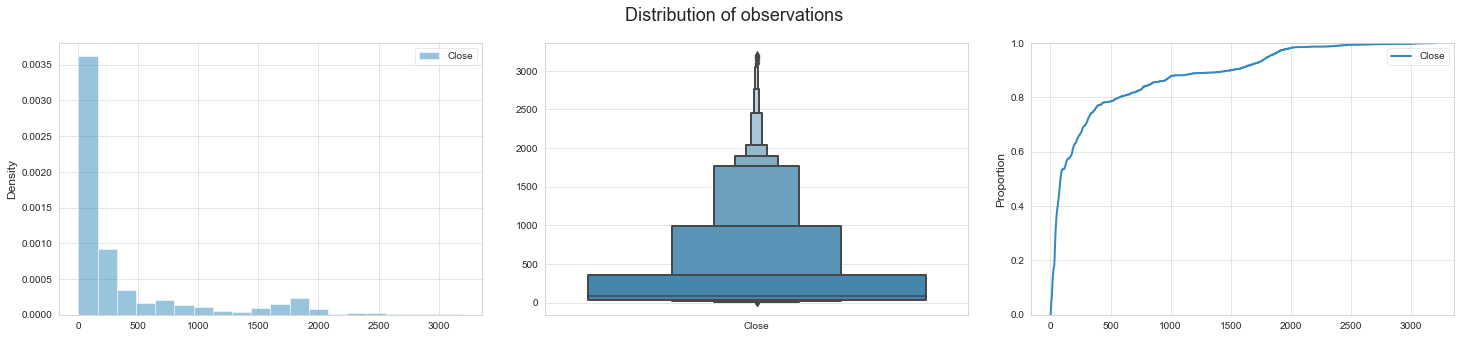

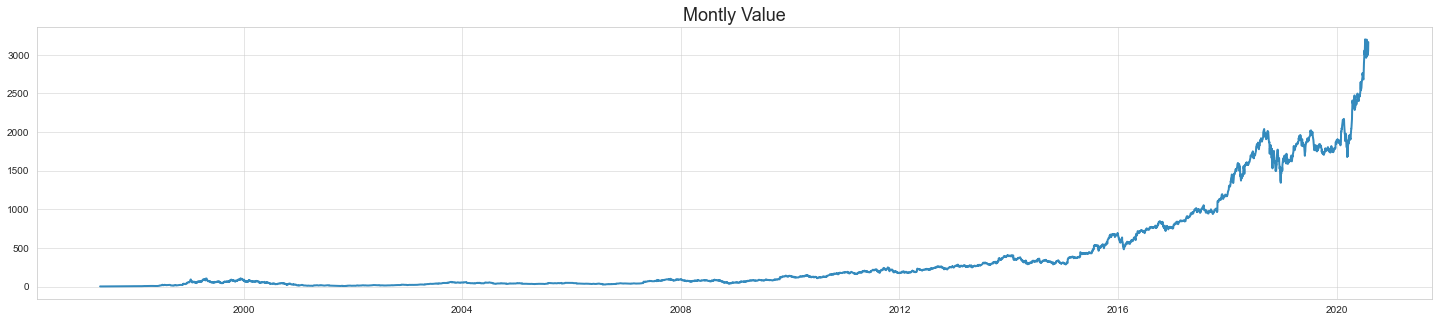

In [9]:
distribution(data_df)

#### Trend analysis

In [10]:
def trend_analysis(data_for_eda):
    # BUILDING MOVING AVERAGES
    
    # 7-day moving average
    data_7d_rol = data_for_eda.rolling(window = 7, center = True).mean()

    # 30-day moving average
    data_30d_rol = data_for_eda.rolling(window = 30, center = True).mean()

    # 365-day moving average
    data_365d_rol = data_for_eda.rolling(window = 365, center = True).mean()
    
    #PLOTTING MOVING AVERAGES
    
    fig, ax = plt.subplots(figsize = (20,5))

    # plotting daily data
    ax.plot(data_for_eda, marker='*', markersize=2, color='0.6',linestyle='None', label='Daily')

    # A fallback version of the presentation
    # ax.plot(novaya_entering_t2, linewidth=2, label='Daily', color='0.6', alpha = 0.5 )

    # plotting 7-day rolling data
    ax.plot(data_7d_rol, linewidth=2, label='7-d Rolling Mean')

    # plotting 30-day rolling data
    ax.plot(data_30d_rol, linewidth=2, label='30-d Rolling Mean')

    # plotting annual rolling data
    ax.plot(data_365d_rol, color='0.2', linewidth=3, label='Trend (365-d Rolling Mean)')

        
    # Beautification of plot
    # ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('People')
    ax.set_title('Trends in series', fontsize=18)

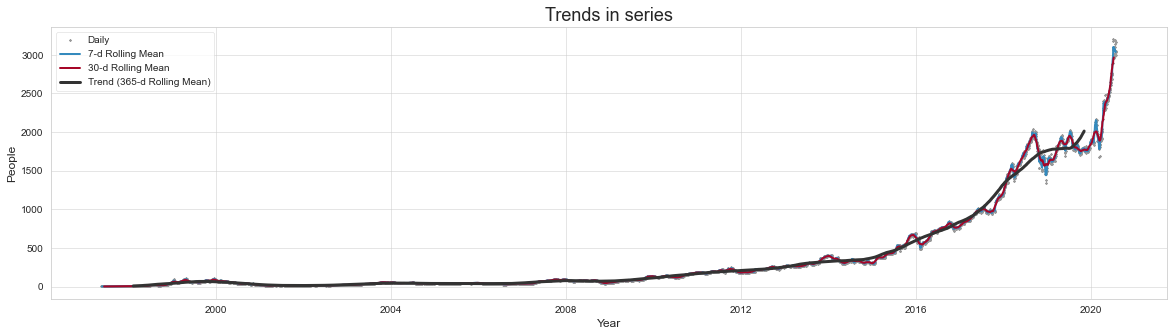

In [11]:
trend_analysis(data_df)

#### Autocorrelation analysis

In [12]:
def autocorr_analysis(data_for_eda):
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 3), dpi= 100)
    plt.suptitle("Autocorrelation analysis", fontsize=18)
    
    sm.graphics.tsa.plot_acf(data_for_eda.values.squeeze(), lags=50, ax=ax[0])
    sm.graphics.tsa.plot_pacf(data_for_eda.values.squeeze(), lags=50, ax=ax[1])
    plt.show()

    fig, ax = plt.subplots(figsize=(19.7, 3), dpi= 100)
    pd.plotting.autocorrelation_plot(data_for_eda, ax=ax)
    plt.show()

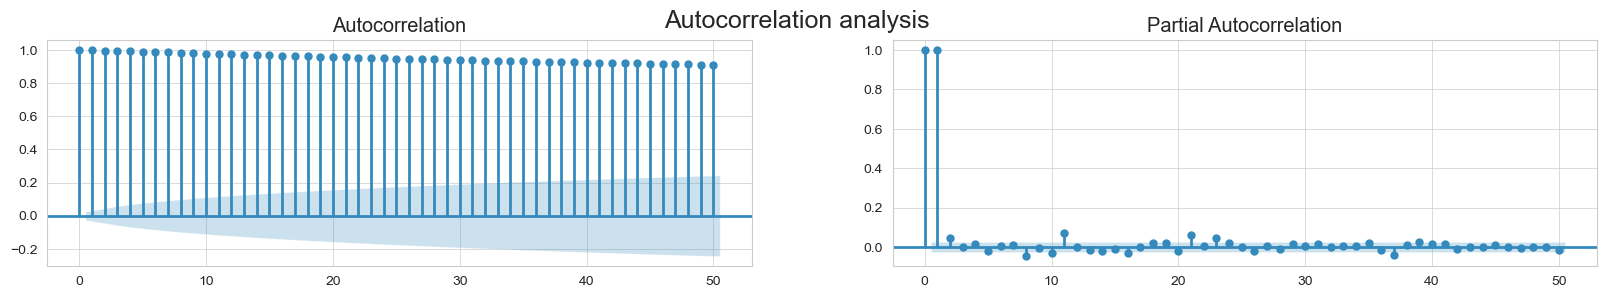

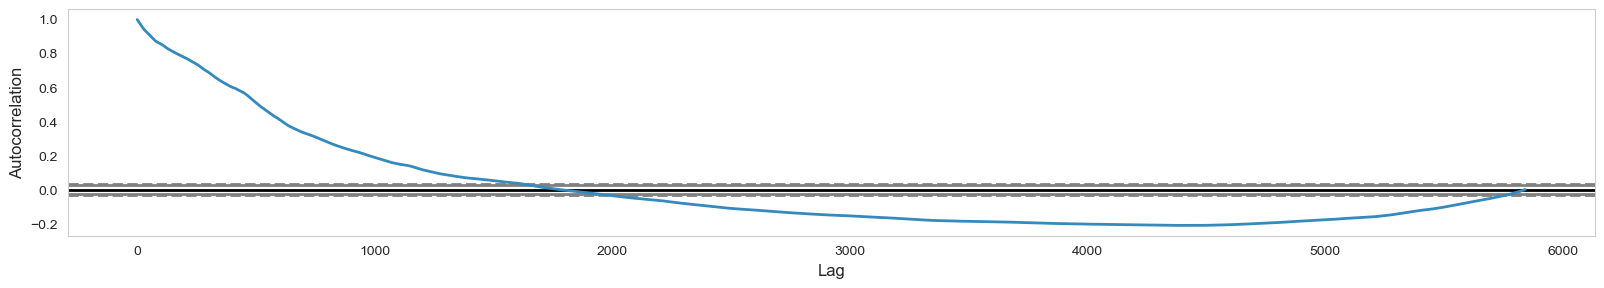

In [13]:
autocorr_analysis(data_df)

#### Analysis of seasonality

In [14]:
def seasonality_analysis(data_for_eda, period=365):
    seasonality = sm.tsa.seasonal_decompose(data_for_eda, model='additive', period=period).seasonal
    fig, ax = plt.subplots(figsize = (20,5))
    ax.plot(seasonality)          

In [15]:
def decomposition(data_for_eda, period=365):
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,5
        
    decomposition = sm.tsa.seasonal_decompose(data_for_eda, model='additive', period=period)
    
    decomposition.plot()
    plt.suptitle("Decomposition", fontsize=18)

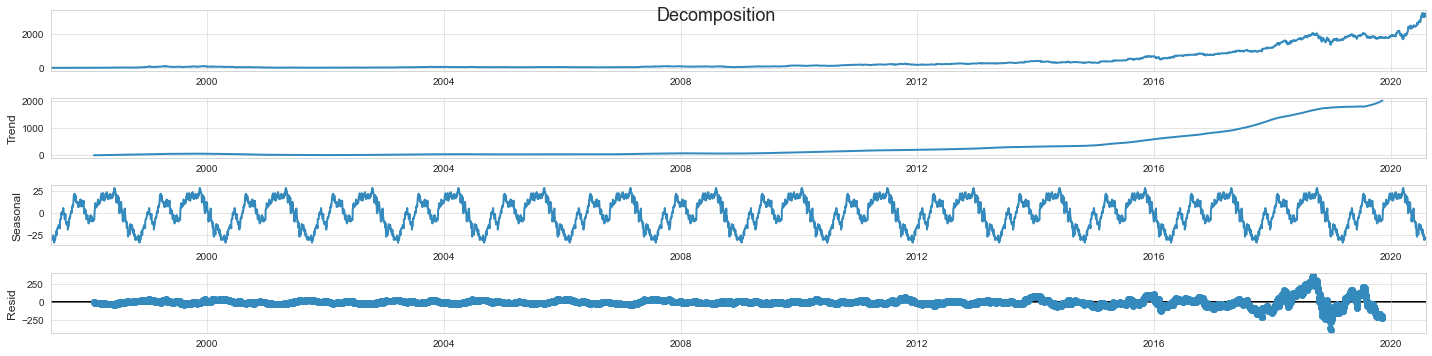

In [16]:
decomposition(data_df, period=365)

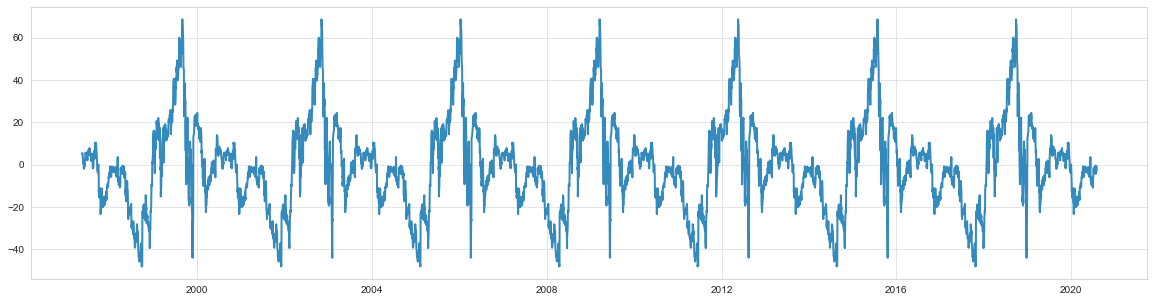

In [17]:
seasonality_analysis(data_df, period=800)

#### Analysis of stationarity

In [18]:
def stationarity_analysis(data_for_eda):
    test = sm.tsa.adfuller(data_for_eda)
    print ('adf:', test[0])
    print ('p-value:', test[1])
    print ('Critical values:', test[4])
    if test[0]> test[4]['5%']: 
        print ('\n There are single roots, the row is not stationary')
    else:
        print ('\n There are no single roots, the row is STATIONARY')

In [19]:
stationarity_analysis(data_df)

adf: 5.618546547149935
p-value: 1.0
Critical values: {'1%': -3.431476604615945, '5%': -2.8620378526446375, '10%': -2.567035004946881}

 There are single roots, the row is not stationary


### DATA PREPARATION

Transform the data into a time series problem

In [20]:
def series_to_supervised(data, n_in=7, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [21]:
values = data_df.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

data_df_norm = series_to_supervised(scaled, n_in=7, n_out=1, dropnan=True)
data_df_norm.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,0.000176,0.000104,0.000098,0.000075,0.000010,0.000000,0.000033,0.000059
8,0.000104,0.000098,0.000075,0.000010,0.000000,0.000033,0.000059,0.000042
9,0.000098,0.000075,0.000010,0.000000,0.000033,0.000059,0.000042,0.000034
10,0.000075,0.000010,0.000000,0.000033,0.000059,0.000042,0.000034,0.000033
11,0.000010,0.000000,0.000033,0.000059,0.000042,0.000034,0.000033,0.000036


In [22]:
values = data_df_norm.values

n_train_time = int(len(data_df)*0.8)

train = values[:n_train_time, :]
test = values[n_train_time:, :]

X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]


X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4673, 1, 7), (1162, 1, 7), (4673,), (1162,))

### LSTM MODEL 

In [23]:
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = LSTM(512, return_sequences=True)(inputs)
x = Dropout(0.5)(x)

x = LSTM(512, return_sequences=True)(x)
x = Dropout(0.5)(x)

x = LSTM(256, return_sequences=True)(x)
x = Dropout(0.5)(x)

x = LSTM(256, return_sequences=True)(x)
x = Dropout(0.5)(x)

x = LSTM(256, return_sequences=True)(x)
x = Dropout(0.5)(x)

x = LSTM(256)(x)
x = Dropout(0.5)(x)

outputs = Dense(1)(x)

model_LSTM = Model(inputs, outputs, name="LSTM_model")

2021-11-10 02:55:04.082667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 02:55:04.088799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 02:55:04.090832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 02:55:04.092445: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [24]:
# Compile model
model_LSTM.compile(loss="mae",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["mae"])

Model: "LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 7)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 512)            1064960   
_________________________________________________________________
dropout (Dropout)            (None, 1, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 512)            2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 256)            787456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 256)            0

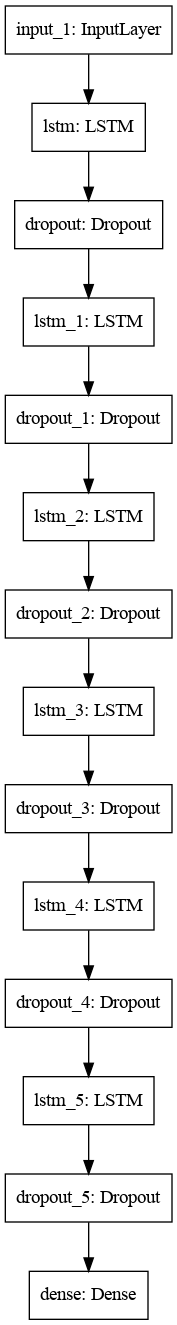

In [25]:
model_LSTM.summary()
tf.keras.utils.plot_model(model_LSTM, to_file='LSTM_model.png')

In [26]:
# Train model
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15,
                                                     restore_best_weights=True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_LSTM.h5",
                                                   save_best_only=True)

model_LSTM_history = model_LSTM.fit(X_train,
                                  y_train,
                                  batch_size=64,
                                  validation_split=0.15,
                                  epochs=500,
                                  callbacks=[early_stopping_cb,
                                            checkpoint_cb])


2021-11-10 02:55:06.934168: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2021-11-10 02:55:15.609248: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8300


63/63 [==============================] - 12s 50ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.1044 - val_mae: 0.1044
Epoch 2/500
63/63 [==============================] - 1s 20ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.1000 - val_mae: 0.1000
Epoch 3/500
63/63 [==============================] - 1s 22ms/step - loss: 0.0127 - mae: 0.0127 - val_loss: 0.0197 - val_mae: 0.0197
Epoch 4/500
63/63 [==============================] - 1s 24ms/step - loss: 0.0040 - mae: 0.0040 - val_loss: 0.0055 - val_mae: 0.0055
Epoch 5/500
63/63 [==============================] - 1s 20ms/step - loss: 0.0034 - mae: 0.0034 - val_loss: 0.0047 - val_mae: 0.0047
Epoch 6/500
63/63 [==============================] - 1s 21ms/step - loss: 0.0033 - mae: 0.0033 - val_loss: 0.0295 - val_mae: 0.0295
Epoch 7/500
63/63 [==============================] - 1s 20ms/step - loss: 0.0034 - mae: 0.0034 - val_loss: 0.0151 - val_mae: 0.0151
Epoch 8/500
63/63 [==============================] - 1s 21ms/step - loss: 0.0029 - mae:

#### EVALUATION RESULT

In [27]:
# EVALUATION AND VISUALIZATION OF MODEL PARAMETERS
def learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(20, 8))
    plt.grid(True)
    plt.title('Learning curves')
    plt.gca().set_ylim(0, 1)
    plt.show()


def evaluation_model(history):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(20, 8))
    axL.plot(history.history['loss'], label="Training loss")
    axL.plot(history.history['val_loss'], label="Validation loss")
    axL.set_title('Training and Validation loss')
    axL.set_xlabel('Epochs')
    axL.set_ylabel('Loss')
    axL.legend(loc='upper right')

    axR.plot(history.history['mae'], label="Training mae")
    axR.plot(history.history['val_mae'], label="Validation mae")
    axR.set_title('Training and Validation mae')
    axR.set_xlabel('Epoch')
    axR.set_ylabel('MAE')
    axR.legend(loc='upper right')

    plt.show()
    
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("People")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)
    
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)


def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

    return mae / mae_naive_no_season


def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

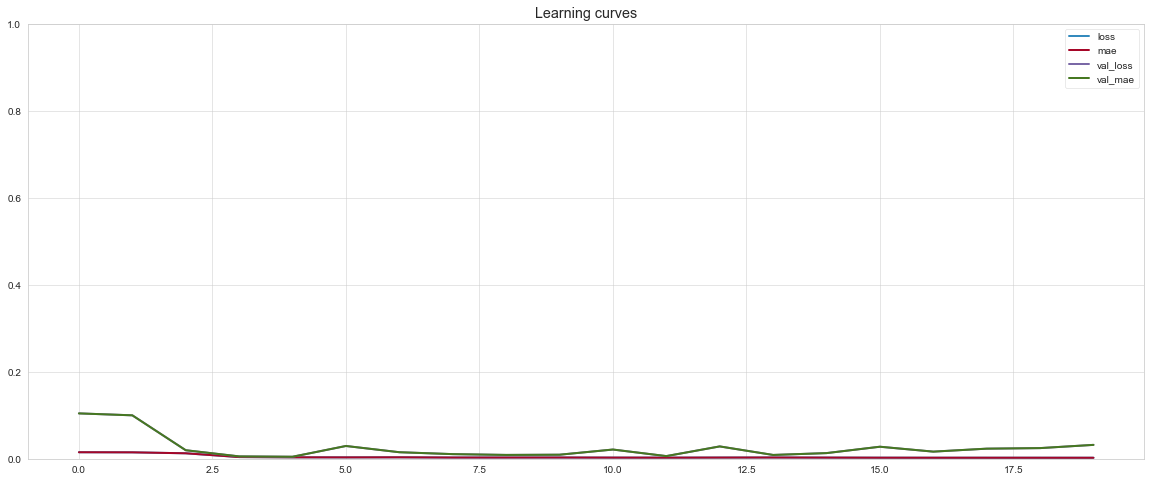

In [28]:
# Learning curves
learning_curves(model_LSTM_history)

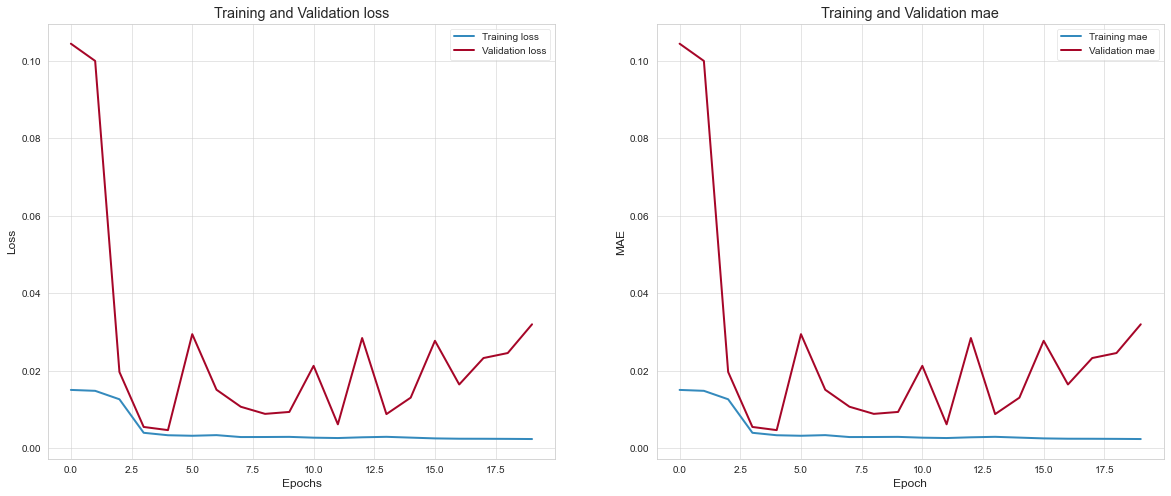

In [29]:
# Evaluation model
evaluation_model(model_LSTM_history)

In [30]:
# Evaluate model on test data
model_LSTM.evaluate(X_test, y_test)

37/37 [==============================] - 0s 9ms/step - loss: 0.1640 - mae: 0.1640


[0.1640160232782364, 0.1640160232782364]

In [31]:
# Load in saved best performing model_1 and evaluate on test data
model_LSTM = tf.keras.models.load_model("model_LSTM.h5")
model_LSTM.evaluate(X_test, y_test)

37/37 [==============================] - 2s 8ms/step - loss: 0.1640 - mae: 0.1640


[0.1640160232782364, 0.1640160232782364]

In [32]:
# Make predictions
model_LSTM_preds = make_preds(model_LSTM, X_test)
model_LSTM_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.1887605 , 0.1887644 , 0.18881673, 0.18952861, 0.18970934,
       0.18982294, 0.18982325, 0.19058366, 0.19138941, 0.1917378 ],
      dtype=float32)>

In [33]:
# Evaluate predictions
model_LSTM_results = evaluate_preds(y_true=tf.squeeze(y_test),
                                   y_pred=model_LSTM_preds)
model_LSTM_results

{'mae': 0.16401604,
 'mse': 0.044410523,
 'rmse': 0.21073805,
 'mape': 30.98748,
 'mase': 27.808035}

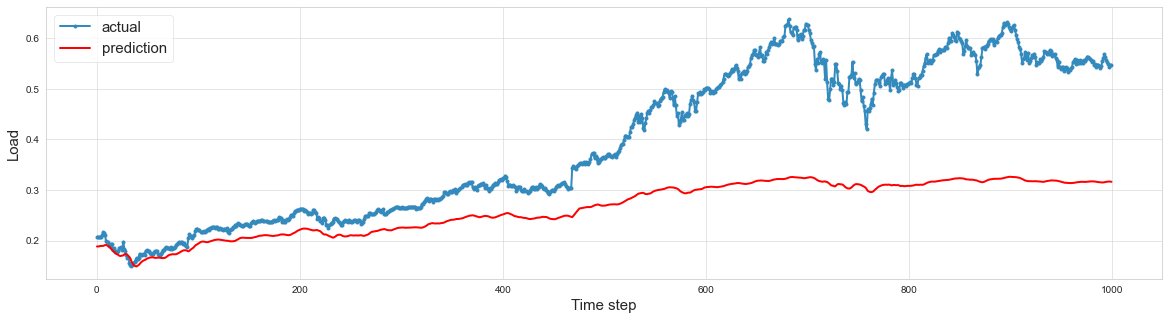

In [34]:
aa=[x for x in range(1000)]
plt.plot(aa, y_test[:1000], marker='.', label="actual")
plt.plot(aa, model_LSTM_preds[:1000], 'r', label="prediction")
plt.ylabel('Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()